In [508]:
import copy

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from scipy.signal import savgol_filter
import matplotlib.gridspec as gridspec
import os as os

path = "./results/"

The load_curves function loads the results of multiple algorithms across different environments from .npy files, stores them in a dictionary structure, and processes them to ensure the curves all have the same length.

In [509]:
def load_curves(algorithms, envs, t):
    curves = {alg: {e: [] for e in envs} for alg in algorithms} # create a dictionary 
    for alg in algorithms:
        for e in envs:
            for i in range(0, 100):
                if t == 0: name = f"{path}/{alg}_{e}_{i}.npy"
                if t == 1: name = f"{path}/{alg}_{e}_{i}_s.npy"
                
                if os.path.isfile(name):
                    #print(f"{name} loaded", np.load(name).shape)
                    curves[alg][e].append(list(np.load(name)))
            max_size = -1        
            for i in range(len(curves[alg][e])):
                if len(curves[alg][e][i]) > max_size:
                    max_size = len(curves[alg][e][i])
            for i in range(len(curves[alg][e])):
                while len(curves[alg][e][i]) <= max_size:
                    curves[alg][e][i].append(curves[alg][e][i][-1])

            curves[alg][e] = np.array(curves[alg][e]) if len(curves[alg][e]) else np.array([[]])
    
    return curves

The smooth function applies a smoothing technique to the loaded data by averaging over a window of neighboring points, creating a more visually appealing curve by reducing fluctuations.

In [510]:
def smooth(data, length=10):
    data = data.copy()
    pad = copy.deepcopy(data[:, -1, None].repeat(length-1, axis=-1)) # padding the data
    pad_data = np.concatenate((data, pad), axis=-1)
    pad = copy.deepcopy(data[:, 0, None].repeat(length-1, axis=-1))  # padding the data
    pad_data = np.concatenate((pad, pad_data), axis=-1)
    
    for i in range(length, len(data[0])+length):
        assert i-length >= 0
        data[:, i-length] = np.mean(pad_data[:, i-length:i+length], axis=-1) # smooth the data with its average
    return data

Plot the results

In [511]:
def plot_results(ENVS, ALGORITHMS, curves, use_median, sample_rates):
    """
    Plots the performance curves for different algorithms in various environments.
    Parameters:
    - ENVS: List of environment names.
    - ALGORITHMS: List of algorithm names.
    - curves: Dictionary of data for each algorithm and environment.
    - use_median: Boolean; if True, use median with quartiles; if False, use mean with std deviation.
    - sample_rates: Dictionary of sampling rates for each algorithm.
    """
    for e in ENVS:
        fig, ax = plt.subplots(1, 1, figsize=(10, 5))
        ax.set_title(e) # Set environment name as the title
        ax.set_xlabel("Time [hours]") # Label for x-axis in hours
        ax.set_xlabel("Steps [1e4]") # Label for x-axis in steps
        ax.set_ylabel("Success rate" if use_median else "Reward") # Label for y-axis
        
        for i, alg in enumerate(ALGORITHMS):
            c = curves[alg][e] # Get data for the algorithm on this environment
            if c.size == 0:
                print(f"No data for {alg} on {e}. Skipping.")
                continue # Skip if there's no data
            
            # Compute the time axis based on the sampling rate
            x = np.arange(c.shape[1]) / sample_rates[alg]   # for hours
            x = np.arange(c.shape[1]) / 2                   # for steps
            
            if use_median:
                # Compute median, 1st quartile (25th percentile), and 3rd quartile (75th percentile)
                median = smooth(np.median(c, axis=0, keepdims=True), length=2).squeeze() # Smooth median
                q1 = smooth(np.percentile(c, 25, axis=0, keepdims=True), length=2).squeeze() # Smooth 25th percentile
                q3 = smooth(np.percentile(c, 75, axis=0, keepdims=True), length=2).squeeze() # Smooth 75th percentile
                ax.plot(x, median, label=alg, linewidth=4, linestyle='-', color='C' + str(i)) # Plot median curve
                ax.fill_between(x, q1, q3, alpha=0.2, color='C' + str(i)) # Fill between 1st and 3rd quartile
            else:
                # Compute mean and standard deviation
                mu = smooth(c.mean(axis=0, keepdims=True), length=2).squeeze() # Smooth mean
                sigma = smooth(c.std(axis=0, keepdims=True), length=2).squeeze() # Smooth std deviation
                ax.plot(x, mu, label=alg, linewidth=4, linestyle='-', color='C' + str(i)) # Plot mean curve
                ax.fill_between(x, mu + sigma, mu - sigma, alpha=0.2, color='C' + str(i)) # Fill between std deviation
        
            ax.set_xticks(np.arange(0, x[-1] + 1, step=1))      # for hours
            ax.set_xticks(np.arange(0, x[-1] + 1, step=10))     # for steps

        ax.grid(True)   # Add grid
        ax.legend()     # Add legend for algorithms
        # ax.set_xlim(0, 10)
        plt.show() # Show the plot

In [512]:
# Define environments and algorithms
ENVS = ['MR-env']
ALGORITHMS = ['OurDDPG', 'ExpD3', 'TD3', 'SAC']

sample_rates = {
    "OurDDPG": 10,  # 10 Hz
    "ExpD3": 15,    # 15 Hz
    "TD3": 8,       # 8 Hz
    "SAC": 5,       # 5 Hz
}

# ENVS = ['MR-env', 'MR-corridor-env']
# ALGORITHMS = ['OurDDPG', 'ExpD3', 'SAC']

Plots the performance curves for each algorithm on each environment.

No data for OurDDPG on MR-env. Skipping.
No data for ExpD3 on MR-env. Skipping.
No data for TD3 on MR-env. Skipping.
No data for SAC on MR-env. Skipping.


/tmp/ipykernel_14476/1552156961.py:46: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()     # Add legend for algorithms


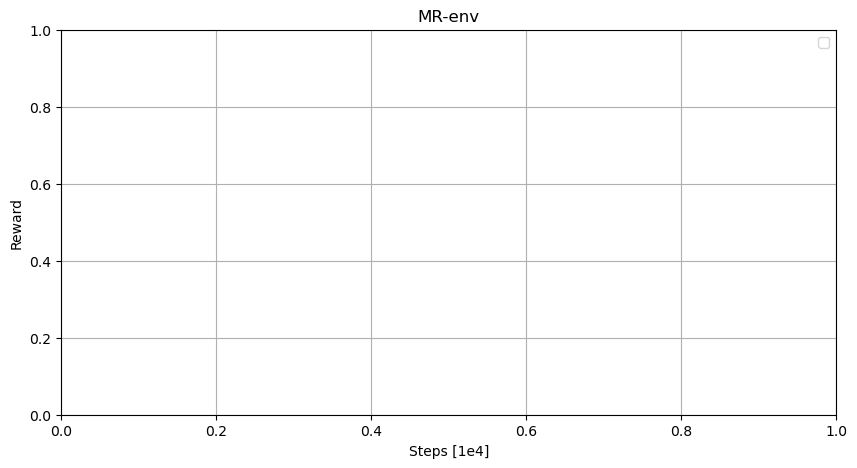

In [513]:
# Load the curves
curves = load_curves(ALGORITHMS, ENVS, t = 0)
# Plot data
plot_results(ENVS, ALGORITHMS, curves, False, sample_rates)

No data for OurDDPG on MR-env. Skipping.
No data for ExpD3 on MR-env. Skipping.
No data for TD3 on MR-env. Skipping.
No data for SAC on MR-env. Skipping.


/tmp/ipykernel_14476/1552156961.py:46: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()     # Add legend for algorithms


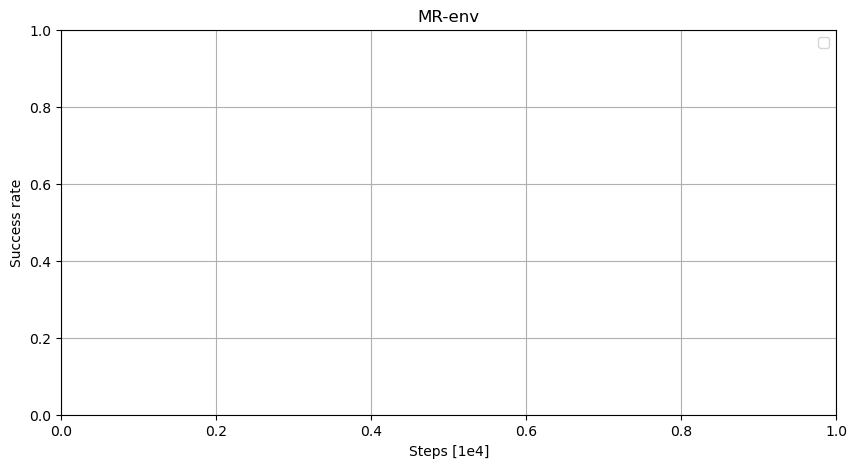

In [514]:
# Load the curves
curves = load_curves(ALGORITHMS, ENVS, t = 1)
# Plot data
plot_results(ENVS, ALGORITHMS, curves, True, sample_rates)

Calculate the time needed to do the experiment, based on the graphs above.

In [515]:
def plot_evaluation_data(data_path, window_size=10):
    """
    Plots evaluation rewards and success over time, with optional smoothing.
    
    Parameters:
    - data_path (str): Path to the .npz data file.
    - window_size (int): The window size for smoothing (default is 10).
    """
    
    # Load the data
    loaded_data = np.load(data_path)
    time = loaded_data['Total_Time_List']  # Assuming this is in seconds
    rewards = loaded_data['Evaluation_Reward_List']
    success = loaded_data['Evaluation_Success_List']

    # Convert time to hours
    time_in_hours = time / 3600

    # Check if the number of data points is sufficient for smoothing
    num_data_points = len(rewards)
    if num_data_points < window_size:
        raise ValueError(f"Insufficient data points for smoothing: {num_data_points} points, but window size is {window_size}.")

    # Smoothing for rewards and success
    smoothed_rewards = np.convolve(rewards, np.ones(window_size) / window_size, mode='valid')
    padded_rewards = np.pad(smoothed_rewards, (window_size // 2, window_size - window_size // 2 - 1), mode='edge')

    smoothed_success = np.convolve(success, np.ones(window_size) / window_size, mode='valid')
    padded_success = np.pad(smoothed_success, (window_size // 2, window_size - window_size // 2 - 1), mode='edge')

    # Ensure the time array has the same length as rewards and success
    if len(time_in_hours) != len(rewards) or len(time_in_hours) != len(success):
        raise ValueError("Time array and rewards/success arrays lengths do not match.")

    # Create a figure with two subplots (one below the other)
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 8), sharex=True)

    # Plot rewards on the first subplot
    ax1.plot(time_in_hours, rewards, label="Evaluation Rewards", color='blue', alpha=0.4)
    ax1.plot(time_in_hours, padded_rewards, label="Smoothed Rewards", color='orange')
    ax1.set_ylabel("Reward")
    ax1.set_title("Rewards over Time")
    ax1.legend()
    ax1.grid(True)

    # Plot success on the second subplot
    ax2.plot(time_in_hours, success, label="Evaluation Success", color='green', alpha=0.4)
    ax2.plot(time_in_hours, padded_success, label="Smoothed Success", color='red')
    ax2.set_xlabel("Time (Hours)")
    ax2.set_ylabel("Success")
    ax2.set_title("Success over Time")
    ax2.legend()
    ax2.grid(True)

    # Adjust layout and show the plot
    plt.tight_layout()
    plt.show()


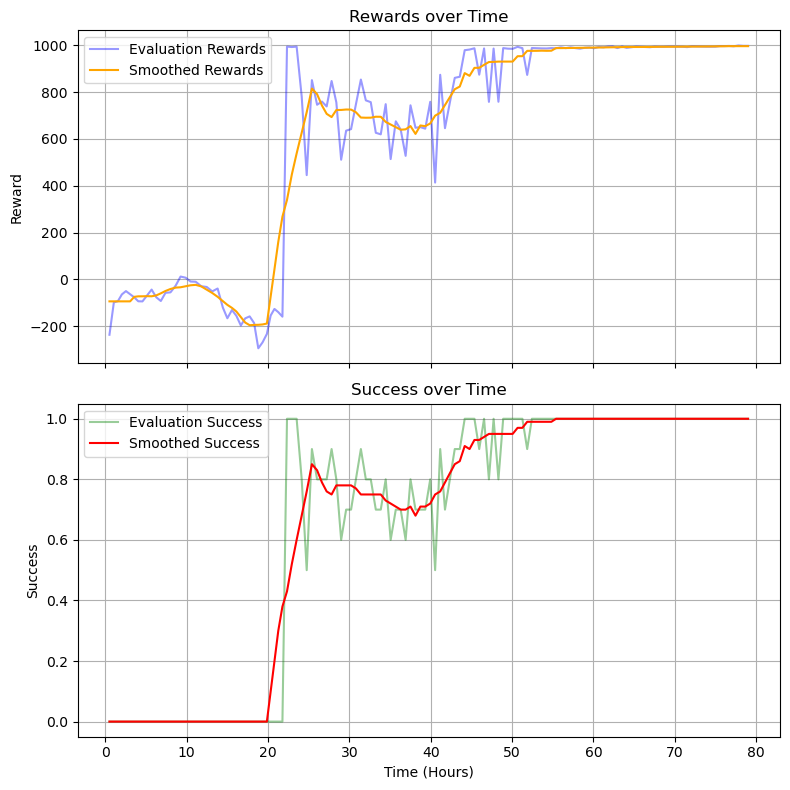

In [516]:
plot_evaluation_data("./results/eval_TD3_64_128_0.npz", window_size=10)

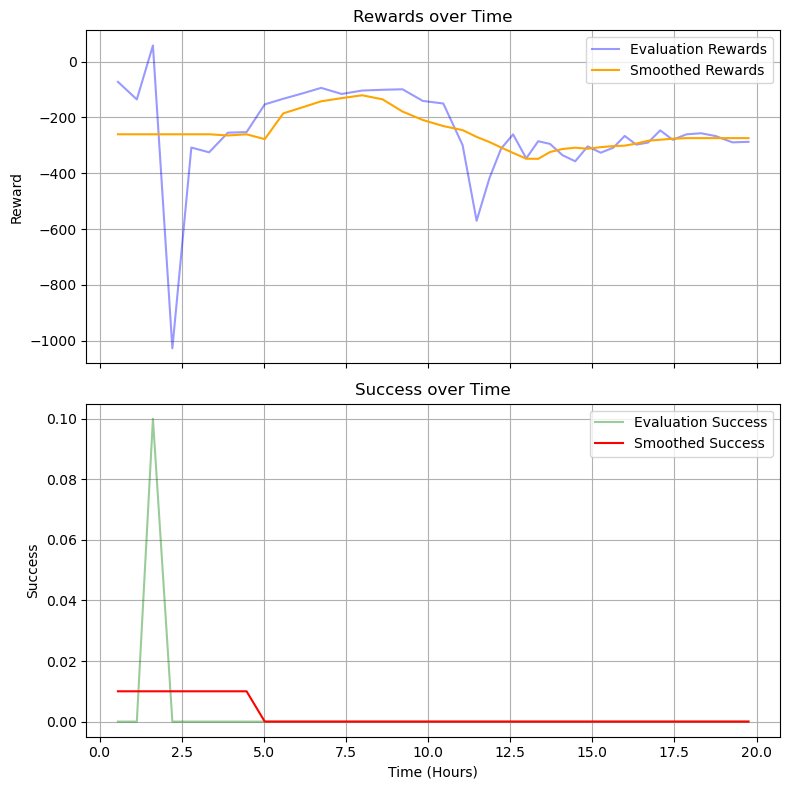

In [517]:
plot_evaluation_data("./results/eval_ExpD3_64_128_0.npz", window_size=10)

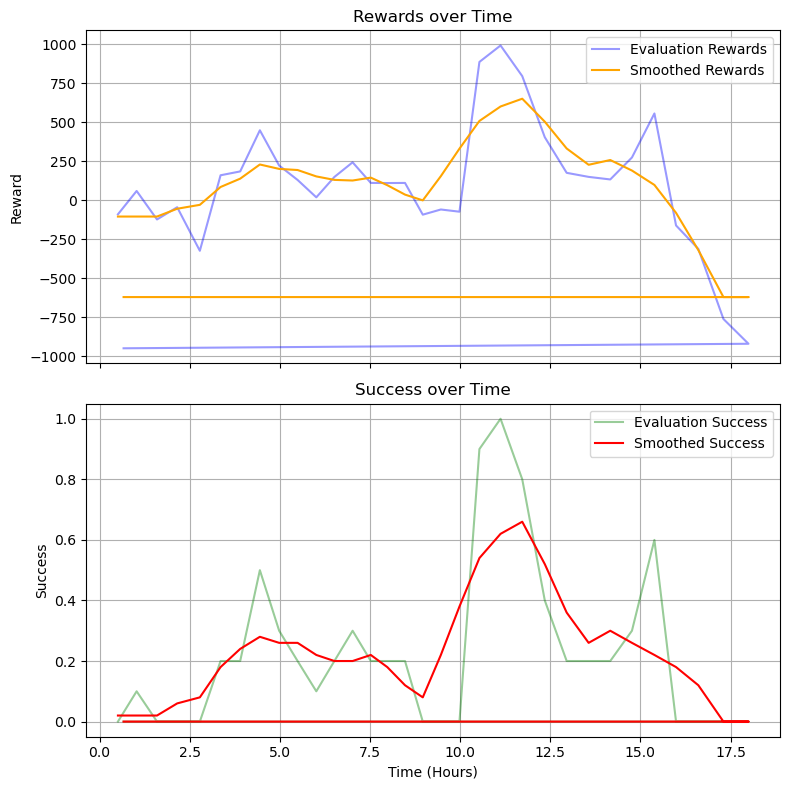

In [518]:
plot_evaluation_data("./results/eval_TD3_64_128_1.npz", window_size=5)

In [519]:
import numpy as np
import matplotlib.pyplot as plt
from typing import List, Dict, Union

class DataPlotter:
    def __init__(self, data_paths: List[str], time_unit: str = 'hours'):
        """
        Initialize the DataPlotter with data paths and time unit.
        
        :param data_paths: List of paths to .npz data files
        :param time_unit: Time unit for conversion ('hours', 'minutes', 'seconds')
        """
        self.data_paths = data_paths
        self.time_unit = time_unit
        self.loaded_data = []
        
        # Time conversion factor
        self.time_conversion = {
            'hours': 3600,
            'minutes': 60,
            'seconds': 1
        }.get(time_unit, None)
        
        if self.time_conversion is None:
            raise ValueError("Invalid time_unit. Choose 'hours', 'minutes', or 'seconds'.")

    def load_data(self, fixed_time_limit: float = 18) -> None:
        """
        Load and preprocess data from provided paths.
        
        :param fixed_time_limit: Time limit for truncation
        """
        # Convert fixed time limit to the same time unit
        fixed_time_limit_converted = fixed_time_limit * 3600 / self.time_conversion
        
        # Reset loaded data
        self.loaded_data = []
        
        # Load and truncate data
        for path in self.data_paths:
            try:
                loaded_data = np.load(path)
                time = loaded_data['Total_Time_List'] / self.time_conversion
                rewards = loaded_data['Evaluation_Reward_List']
                success = loaded_data['Evaluation_Success_List']
                
                # Find the maximum index where time is within the fixed limit
                max_idx = np.searchsorted(time, fixed_time_limit_converted, side='right')
                
                # Truncate arrays to the fixed time limit
                self.loaded_data.append({
                    'time': time[:max_idx],
                    'rewards': rewards[:max_idx],
                    'success': success[:max_idx]
                })
            except Exception as e:
                print(f"Error processing {path}: {e}")
        
        if not self.loaded_data:
            raise ValueError("No valid data files found")

    def _truncate_data(self) -> List[Dict[str, np.ndarray]]:
        """
        Truncate loaded data to the smallest common length.
        
        :return: List of truncated data dictionaries
        """
        # Determine the minimum length across all truncated datasets
        min_length = min(len(data['rewards']) for data in self.loaded_data)
        
        # Further truncate all arrays to the smallest length
        return [
            {
                'time': data['time'][:min_length],
                'rewards': data['rewards'][:min_length],
                'success': data['success'][:min_length]
            }
            for data in self.loaded_data
        ]

    def plot_evaluation_data(self, 
                              figsize: tuple = (10, 8), 
                              save_path: Union[str, None] = None) -> None:
        """
        Plot evaluation rewards and success over time.
        
        :param figsize: Figure size for the plot
        :param save_path: Optional path to save the figure
        """
        # Ensure data is loaded
        if not self.loaded_data:
            self.load_data()
        
        # Truncate data
        truncated_data = self._truncate_data()
        
        # Compute mean and standard deviation
        mean_time = np.mean([data['time'] for data in truncated_data], axis=0)
        mean_rewards = np.mean([data['rewards'] for data in truncated_data], axis=0)
        std_rewards = np.std([data['rewards'] for data in truncated_data], axis=0)
        q1_success = np.percentile([data['success'] for data in truncated_data], 25, axis=0)
        q3_success = np.percentile([data['success'] for data in truncated_data], 75, axis=0)
        median_success = np.median([data['success'] for data in truncated_data], axis=0)

        
        # Create plot
        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=figsize, sharex=True)
        
        # Rewards subplot
        ax1.plot(mean_time, mean_rewards, label="Mean Rewards", color='blue', alpha=0.8)
        ax1.fill_between(mean_time, mean_rewards - std_rewards, mean_rewards + std_rewards, 
                         color='blue', alpha=0.2, label="Variance")
        ax1.set_ylabel("Reward")
        ax1.set_title(f"Rewards over Time ({self.time_unit})")
        ax1.legend()
        ax1.grid(True)
    
        # Success subplot using quartiles
        ax2.plot(mean_time, median_success, label="Median Success", color='green', alpha=0.8)
        ax2.fill_between(mean_time, q1_success, q3_success, 
                        color='green', alpha=0.2, label="IQR (Q1-Q3)")
        ax2.set_xlabel(f"Time ({self.time_unit})")
        ax2.set_ylabel("Success")
        ax2.set_title("Success over Time")
        ax2.legend()
        ax2.grid(True)

        
        plt.tight_layout()
        
        # Save or show the plot
        if save_path:
            plt.savefig(save_path)
        else:
            plt.show()

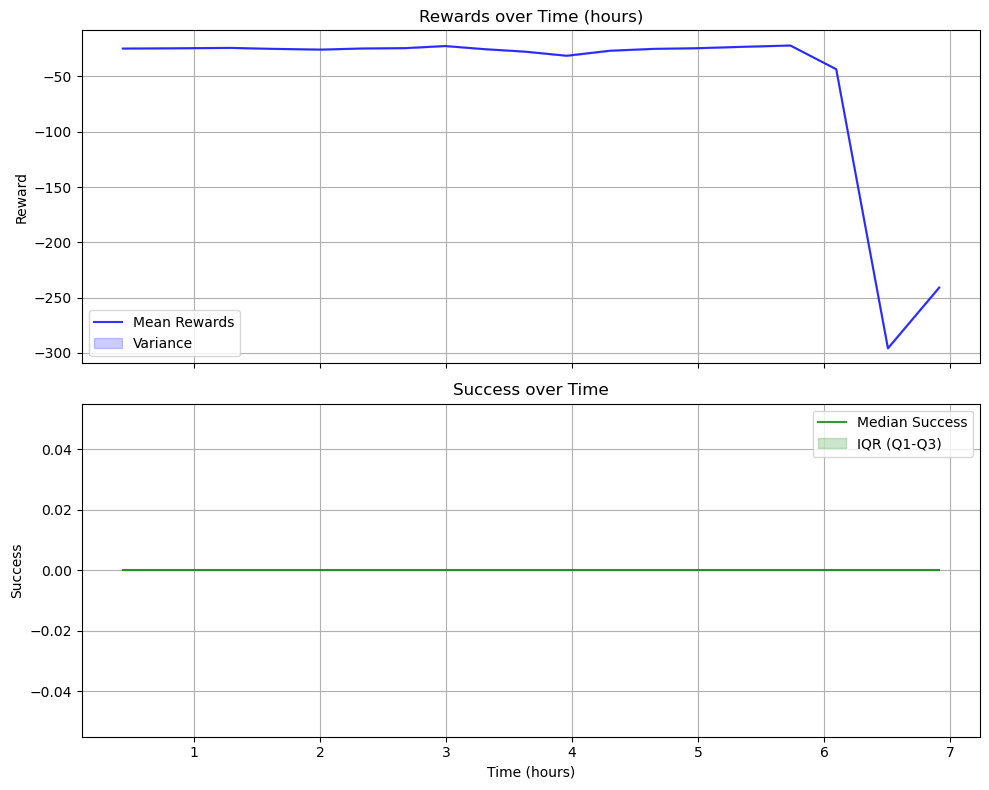

In [520]:
# Example usage
data_paths = [
    "./results/eval_TD3_64_128_0.npz", 
    "./results/eval_TD3_64_128_1.npz",
    "./results/eval_TD3_64_128_2.npz", 
    "./results/eval_TD3_64_128_3.npz",
    "./results/eval_TD3_64_128_4.npz"
]

# Example usage
data_paths = [
    "./results/eval_ExpD3_64_128_0.npz",
    "./results/eval_ExpD3_64_128_1.npz",
    "./results/eval_ExpD3_64_128_2.npz",
    "./results/eval_ExpD3_64_128_3.npz",
    "./results/eval_ExpD3_64_128_4.npz",
    "./results/eval_ExpD3_64_128_5.npz"
]

data_paths = [
    "./results/eval_TD3_256_256_0.npz", 
    "./results/eval_TD3_256_256_1.npz",
    "./results/eval_TD3_256_256_2.npz", 
    "./results/eval_TD3_256_256_3.npz",
    "./results/eval_TD3_256_256_4.npz"
]

# Create plotter instance
plotter = DataPlotter(data_paths[:1])

# Load and plot data

plotter.load_data(fixed_time_limit=40)
plotter.plot_evaluation_data(save_path='./images/evaluation_plot_' + data_paths[1][15:-6] + '.png')